In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.read_data import read_timeseries_s22, read_weather_s22
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import h5py


#%matplotlib inline
%matplotlib widget

set_mpl()

matplotlib settings set
matplotlib settings set


In [3]:
weather = read_weather_s22()

energy = read_timeseries_s22()[['P_substation']]


for df in [energy, weather]:
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    df['season'] = df['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
    df['workday'] = df['weekday'].apply(lambda x: 'workday' if x in [0, 1, 2, 3, 4] else 'weekend')



READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/2018_weather.hdf5
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/2019_weather.hdf5
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/2020_weather.hdf5
READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/
DATA LOADED FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/. 
 Houses number removed: 24, 25. 
 Houses with PV: ['13', '15', '26', '33'] 
 HOUSEHOLD and HEATPUMP energy consumption are separated. 
 Resolution: 60min 
 Years: 2018
READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/
DATA LOADED FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Schlemminger2022/. 
 Houses number removed: 24, 25. 
 Houses with PV: ['13', '15', '26', '33'] 
 HOUSEHOLD and HEATPUMP energy consumption are separated. 

# DARTS time series package

## init darts

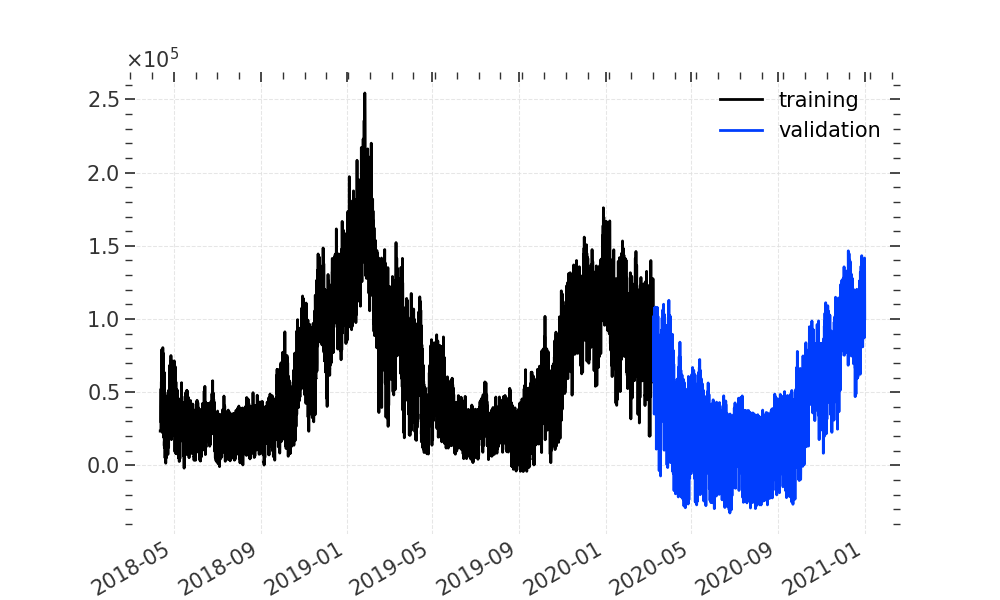

In [19]:
from darts import TimeSeries
from darts.metrics import mape

series = TimeSeries.from_dataframe(energy[['P_substation']],freq='H')

fig,  ax =  plt.subplots( figsize = (10,6))
train, val = series.split_before(0.7)
train.plot(label="training", ax=ax)
val.plot(label="validation", ax=ax)


## dummy model

MAPE: 22.92%


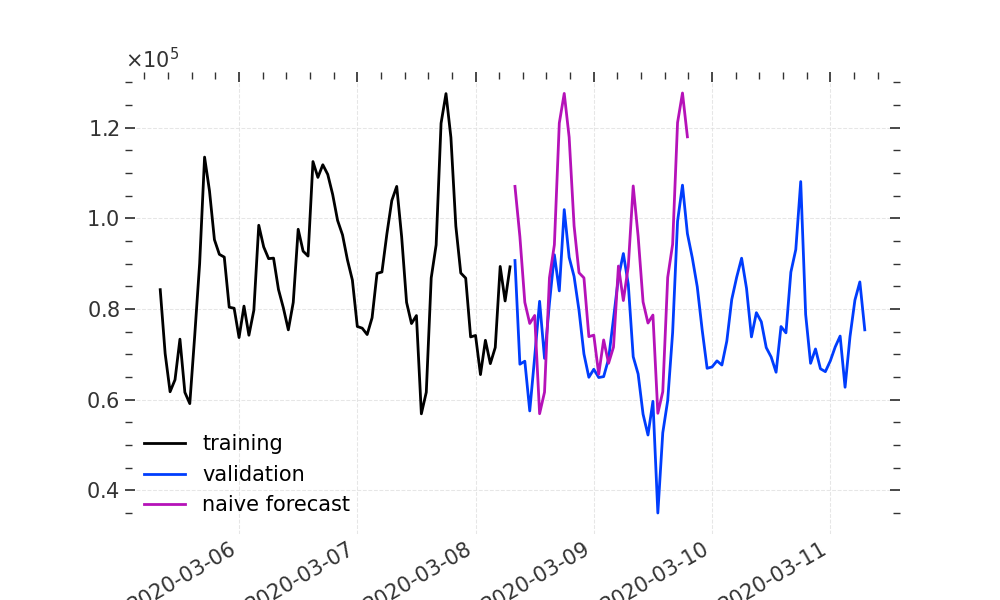

In [21]:
from darts.models import NaiveSeasonal
from darts.models import NaiveDrift

naive_model = NaiveSeasonal(K=24)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

naive_drift = NaiveDrift()
naive_drift.fit(train)
naive_drift_forecast = naive_drift.predict(36)

forecast = naive_forecast + naive_drift_forecast - train.last_value()

fig,  ax =  plt.subplots( figsize = (10,6))

train.tail(24*3).plot(label="training", ax=ax)
val.head(24*3).plot(label="validation", ax=ax)
forecast.plot(label="naive forecast", ax=ax)

print('MAPE: {:.2f}%'.format(mape(val, forecast)))


## more complicated models

In [23]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

eval_model(AutoARIMA())
eval_model(Theta())

KeyboardInterrupt: 